### 가장 성능이 좋았던 모델에 비선형 변환 적용
* 가스공급량 데이터에 비선형 변환 적용

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [199]:
total = pd.read_csv("../CSV/train_data.csv")
test = pd.read_csv("../CSV/pred_test.csv")

print("total shape : {}, test shape : {}".format(total.shape, test.shape))

total shape : (368088, 12), test shape : (15120, 12)


In [200]:
total.head(3)

,연월일,시간,일시,year,month,day,hour,weekday,구분,구분_int,공급량,기온(°C)
0,2013-01-01,1,2013-01-01 00:00:00,2013,1,1,0,1,A,0,2497.129,-8.3
1,2013-01-01,2,2013-01-01 01:00:00,2013,1,1,1,1,A,0,2363.265,-8.5
2,2013-01-01,3,2013-01-01 02:00:00,2013,1,1,2,1,A,0,2258.505,-8.4


In [201]:
def nmae(true_df, pred_df):
    target_idx = true_df.iloc[:,0]
    pred_df = pred_df[pred_df.iloc[:,0].isin(target_idx)]
    pred_df = pred_df.sort_values(by=[pred_df.columns[0]], ascending=[True])
    true_df = true_df.sort_values(by=[true_df.columns[0]], ascending=[True])
    
    true = true_df.iloc[:,1].to_numpy()
    pred = pred_df.iloc[:,1].to_numpy()
    
    score = np.mean((np.abs(true-pred))/true)
    
    return score

In [202]:
train_years = [2013,2014,2015,2016,2017]
val_years = [2018]

train = total[total['year'].isin(train_years)]
val = total[total['year'].isin(val_years)]

# "year", "month", "day", "hour", "weekday", "구분_int", "기온(°C)"
features = ["month", "hour", "구분_int", "기온(°C)"]
# features = ["year", "month", "day", "hour", "weekday", "구분_int", "기온(°C)"]
train_x = train[features]
train_y = np.log1p(train["공급량"])

val_x = val[features]
val_y = val['공급량']

X = total[features]
y = total["공급량"]

In [187]:
d_train = lgb.Dataset(train_x, train_y)
d_val = lgb.Dataset(val_x, val_y)

# kfold = KFold(n_splits = 10, shuffle = True, random_state = 27)
MSE = []
NMAE = []
for i in range(1, 17, 1) :
    params = {
        'objective': 'regression',
        'metric':'mae',
        'seed':42, 
        "learning_rate" : 0.1, 
        "max_depth" : f"{i}"
    }

    model = lgb.train(params, d_train, 1000, d_val, verbose_eval=20, early_stopping_rounds=10)

#     pred = model.predict(val_x)
    pred = np.expm1(model.predict(val_x))

    true_y = pd.DataFrame({"y" : val_y})
    pred_y = pd.DataFrame({"pred_y" : pred})

    true_y.reset_index(drop = True, inplace = True)
    true_y.reset_index(inplace = True)
    pred_y.reset_index(inplace = True)

    # cross_score = cross_val_score(model, X, y, cv = 3)

    train_mse = mean_squared_error(val_y, pred)
    print("MSE :", train_mse)
    print("NMAE : {:.6f}".format(nmae(true_y, pred_y)))
    MSE.append(train_mse)
    NMAE.append(nmae(true_y, pred_y))


/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 306768, number of used features: 4
[LightGBM] [Info] Start training from score 6.296359
Training until validation scores don't improve for 10 rounds
[20]	valid_0's l1: 1008.1
[40]	valid_0's l1: 1008.09
[60]	valid_0's l1: 1008.08
[80]	valid_0's l1: 1008.08
[100]	valid_0's l1: 1008.07
[120]	valid_0's l1: 1008.07
[140]	valid_0's l1: 1008.07
[160]	valid_0's l1: 1008.06
[180]	valid_0's l1: 1008.06
[200]	valid_0's l1: 1008.06
[220]	valid_0's l1: 1008.06
[240]	valid_0's l1: 1008.05
[260]	valid_0's l1: 1008.05
[280]	valid_0's l1: 1008.05
[300]	valid_0's l1: 1008.05
[320]	valid_0's l1: 1008.05
[340]	valid_0's l1: 1008.05
[360]	valid_0's l1: 1008.05
[380]	valid_0's l1: 1008.05
[400

/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 10 rounds
[20]	valid_0's l1: 1008.08
[40]	valid_0's l1: 1008.06
[60]	valid_0's l1: 1008.05
[80]	valid_0's l1: 1008.05
[100]	valid_0's l1: 1008.05
[120]	valid_0's l1: 1008.04
[140]	valid_0's l1: 1008.04
[160]	valid_0's l1: 1008.04
[180]	valid_0's l1: 1008.04
[200]	valid_0's l1: 1008.04
[220]	valid_0's l1: 1008.04
Early stopping, best iteration is:
[211]	valid_0's l1: 1008.04
MSE : 57808.00008501455
NMAE : 0.472731
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 306768, number of used features: 4
[LightGBM] [Info] Start training from score 6.296359
Training until validation scores don't improve for 10 rounds


/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l1: 1008.07
[40]	valid_0's l1: 1008.06
[60]	valid_0's l1: 1008.05
[80]	valid_0's l1: 1008.05
[100]	valid_0's l1: 1008.04
[120]	valid_0's l1: 1008.04
Early stopping, best iteration is:
[123]	valid_0's l1: 1008.04
MSE : 46183.541544440544
NMAE : 0.489383
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 306768, number of used features: 4
[LightGBM] [Info] Start training from score 6.296359
Training until validation scores don't improve for 10 rounds
[20]	valid_0's l1: 1008.07
[40]	valid_0's l1: 1008.05
[60]	valid_0's l1: 1008.05
[80]	valid_0's l1: 1008.05
Early stopping, best iteration is:
[73]	valid_0's l1: 1008.04


/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


MSE : 48791.60890664235
NMAE : 0.490965
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 306768, number of used features: 4
[LightGBM] [Info] Start training from score 6.296359
Training until validation scores don't improve for 10 rounds
[20]	valid_0's l1: 1008.06
[40]	valid_0's l1: 1008.05
[60]	valid_0's l1: 1008.05
Early stopping, best

/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


MSE : 48440.91962279915
NMAE : 0.504018
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 306768, number of used features: 4
[LightGBM] [Info] Start training from score 6.296359
Training until validation scores don't improve for 10 rounds
[20]	valid_0's l1: 1008.06
[40]	valid_0's l1: 1008.05


/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[60]	valid_0's l1: 1008.05
Early stopping, best iteration is:
[54]	valid_0's l1: 1008.05
MSE : 50965.39390087396
NMAE : 0.509058
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 306768, number of used features: 4
[LightGBM] [Info] Start training from score 6.296359
Training until validation scores don't improve for 10 rounds
[20]	valid_0

/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[40]	valid_0's l1: 1008.05
Early stopping, best iteration is:
[40]	valid_0's l1: 1008.05
MSE : 73473.61394634332
NMAE : 0.518605
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 306768, number of used features: 4
[LightGBM] [Info] Start training from score 6.296359
Training until validation scores don't improve for 10 rounds
[20]	valid_0

/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[40]	valid_0's l1: 1008.05
Early stopping, best iteration is:
[40]	valid_0's l1: 1008.05
MSE : 76539.08964216428
NMAE : 0.514782
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 306768, number of used features: 4
[LightGBM] [Info] Start training from score 6.296359
Training until validation scores don't improve for 10 rounds
[20]	valid_0

/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[40]	valid_0's l1: 1008.05
Early stopping, best iteration is:
[46]	valid_0's l1: 1008.05
MSE : 64342.047898396464
NMAE : 0.521575
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 306768, number of used features: 4
[LightGBM] [Info] Start training from score 6.296359
Training until validation scores don't improve for 10 rounds
[20]	valid_

/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[40]	valid_0's l1: 1008.05
[60]	valid_0's l1: 1008.05
[80]	valid_0's l1: 1008.05
[100]	valid_0's l1: 1008.05
Early stopping, best iteration is:
[101]	valid_0's l1: 1008.05
MSE : 39003.93818629629
NMAE : 0.512434
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 306768, number of used features: 4
[LightGBM] [Info] Start training from score

/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[40]	valid_0's l1: 1008.05
[60]	valid_0's l1: 1008.05
[80]	valid_0's l1: 1008.05
Early stopping, best iteration is:
[80]	valid_0's l1: 1008.05
MSE : 42166.831941847166
NMAE : 0.511965
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 306768, number of used features: 4
[LightGBM] [Info] Start training from score 6.296359
Training until val

/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[60]	valid_0's l1: 1008.05
[80]	valid_0's l1: 1008.05
Early stopping, best iteration is:
[83]	valid_0's l1: 1008.05
MSE : 41797.41822738554
NMAE : 0.514980
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 306768, number of used features: 4
[LightGBM] [Info] Start training from score 6.296359
Training until validation scores don't improve

/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l1: 1008.06
[40]	valid_0's l1: 1008.05
[60]	valid_0's l1: 1008.05
[80]	valid_0's l1: 1008.05
Early stopping, best iteration is:
[83]	valid_0's l1: 1008.05
MSE : 41754.4499260716
NMAE : 0.514723
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 306768, number of used features: 4
[LightGBM] [Info] Start training from score 6.

/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[40]	valid_0's l1: 1008.05
[60]	valid_0's l1: 1008.05
Early stopping, best iteration is:
[56]	valid_0's l1: 1008.05
MSE : 52405.14762856789
NMAE : 0.521768
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 306768, number of used features: 4
[LightGBM] [Info] Start training from score 6.296359
Training until validation scores don't improve

/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[40]	valid_0's l1: 1008.05
[60]	valid_0's l1: 1008.05
[80]	valid_0's l1: 1008.05
Early stopping, best iteration is:
[80]	valid_0's l1: 1008.05
MSE : 42435.89923004157
NMAE : 0.517489
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 306768, number of used features: 4
[LightGBM] [Info] Start training from score 6.296359
Training until vali

/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's l1: 1008.06
[40]	valid_0's l1: 1008.05
[60]	valid_0's l1: 1008.05
[80]	valid_0's l1: 1008.05
Early stopping, best iteration is:
[71]	valid_0's l1: 1008.05
MSE : 44872.95197443433
NMAE : 0.518289


In [188]:
df = pd.DataFrame({"MSE" : MSE, "NMAE" : NMAE})
df

,MSE,NMAE
0,83551.581311,0.498777
1,57808.000085,0.472731
2,46183.541544,0.489383
3,48791.608907,0.490965
4,48440.919623,0.504018
5,50965.393901,0.509058
6,73473.613946,0.518605
7,76539.089642,0.514782
8,64342.047898,0.521575
9,39003.938186,0.512434


### 13번째 제출 모델

In [203]:
d_train = lgb.Dataset(train_x, train_y)
d_val = lgb.Dataset(val_x, val_y)

# kfold = KFold(n_splits = 10, shuffle = True, random_state = 27)

params = {
    'objective': 'regression',
    'metric':'mae',
    'seed':42, 
    "learning_rate" : 0.1, 
    "max_depth" : 17
}

model = lgb.train(params, d_train, 1000, d_val, verbose_eval=20, early_stopping_rounds=10)

# pred = model.predict(val_x)
pred = np.expm1(model.predict(val_x))
true_y = pd.DataFrame({"y" : val_y})
pred_y = pd.DataFrame({"pred_y" : pred})

true_y.reset_index(drop = True, inplace = True)
true_y.reset_index(inplace = True)
pred_y.reset_index(inplace = True)

# cross_score = cross_val_score(model, X, y, cv = 3)

train_mse = mean_squared_error(val_y, pred)
print("MSE :", train_mse)
print("NMAE : {:.6f}".format(nmae(true_y, pred_y)))

/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/seungwoomun/opt/anaconda3/envs/likelion/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 306768, number of used features: 4
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 6.296359
Training until validation scores don't improve for 10 rounds
[20]	valid_0's l1: 1008.06
[40]	valid_0's l1: 1008.05
[60]	valid_0's l1: 1008.05
[80]	valid_0's l1: 1008.05
Early stopping, best iteration is

In [190]:
submission = pd.read_csv('../CSV/가스공급량 수요예측 모델개발 data/sample_submission.csv')

In [191]:
test_x = test[features]
preds = np.expm1(model.predict(test_x))
submission['공급량'] = preds
submission.to_csv("../CSV/Submission/14_4_features_lightgbm_model.csv", index = False)

In [197]:
submission.head(3)

,일자|시간|구분,공급량
0,2019-01-01 01 A,2317.388492
1,2019-01-01 02 A,2018.930936
2,2019-01-01 03 A,1901.809367


In [192]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize = (10, 12))
# plot_importance(model, ax = ax)

In [193]:
# true_y = pd.DataFrame({"y" : np.expm1(val_y)})
# pred_y = pd.DataFrame({"pred_y" : np.expm1(pred)})

# true_y.reset_index(drop = True, inplace = True)
# true_y.reset_index(inplace = True)
# pred_y.reset_index(inplace = True)

In [194]:
true_y

,index,y
0,0,1765.008
1,1,1679.186
2,2,1610.885
3,3,1604.123
4,4,1711.506
...,...,...
61315,61315,681.033
61316,61316,669.961
61317,61317,657.941
61318,61318,610.953


In [195]:
pred_y

,index,pred_y
0,0,1975.377523
1,1,1762.404670
2,2,1653.405481
3,3,1653.405481
4,4,1867.527604
...,...,...
61315,61315,577.686413
61316,61316,596.861721
61317,61317,597.850031
61318,61318,587.283599


In [196]:
merge_df = pd.merge(true_y, pred_y, on = "index")
merge_df["오차"] = merge_df["pred_y"] - merge_df["y"]
merge_df.describe()

,index,y,pred_y,오차
count,61320.00000,61320.000000,61320.000000,61320.000000
mean,30659.50000,1014.316302,932.208847,-82.107455
std,17701.70359,1009.644343,909.284195,198.601487
min,0.00000,2.756000,26.989482,-1775.809445
25%,15329.75000,236.663750,234.295990,-146.278775
50%,30659.50000,679.869500,638.333355,-27.227144
75%,45989.25000,1482.117000,1350.274047,16.142681
max,61319.00000,6641.641000,5130.270850,1027.590433


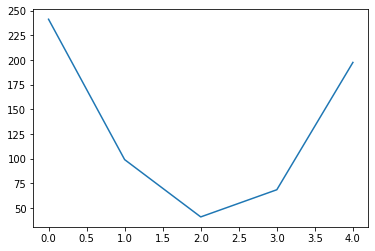

In [158]:
plt.plot(merge_df["오차"][:5])